# Specifying dissimilarities for MPSE

In [1]:
import sys; sys.path.insert(0,"../")
import numpy as np

import mview

You can run the MPSE algorithm using multiple types of inputs, including matrices, coordinates/features, and graphs. You can also ask MPSE to produce random sets of dissimilarities.

In what follows, we will always set up the dissimilarity relations using the class mview.DISS. For simple inputs, it is possible to skip this step (see quick_inputs.ipynb).

We will be using these parameters in all of the computations:

In [20]:
node_number = 128 #number of nodes/points
average_neighbors = 4 #average number of neighbors per node used in estimating 
#cost and gradients at each iteration (stochastic gradient descent)
max_iter = 200 #maximum number of iterations
min_grad = 1e-5 #early stopping criterion: end if gradient is small

The following sections go over running MPSE (mostly with default parameters) for different types of input dissimilarity sets. The input types are organized by section as follows:

1) distance/dissimilarity matrices and features/coordinates

2) data produced from projections of random data

3) graphs (TBW)

4) subgraphs (TBW)

## Running MPSE with your own data

To begin, let us use MPSE with dissimilarity relations obtained from a physical example (so the embedding should be exactly recovable). We define the 3D positions of $N$ nodes (with coordinates randomly sampled from a normal distribution). We consider 3 perspectives, corresponding to the 3 standard projections from 3D to 2D.

In [21]:
X = np.random.randn(node_number,3) #positions in 3D
Y1 = X[:,[1,2]] #projection of data into 2D, viewed from x-direction
Y2 = X[:,[2,0]]
Y3 = X[:,[0,1]]

### Using dissimilarity matrices

Let us compute a dissimilarity matrix for each perspective, which we will then use as input for MPSE.

In [22]:
from scipy.spatial import distance_matrix
D1 = distance_matrix(Y1,Y1) #pairwise distance matrix of Y1
D2 = distance_matrix(Y2,Y2)
D3 = distance_matrix(Y3,Y3)

To run MPSE using the dissimilarity matrices as inputs, we set up 

diss = mview.DISS(node_number=node_number,verbose=1)
diss.add_matrix(D1)
diss.add_matrix(D2)
diss.add_matrix(D3)
mv = mview.basic(diss,average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY()
mv.figureH()

### Using features

Instead of using the entire dissimilarity matrices as inputs (which takes a long time to compute for large number of points), you can just specify positions/features of each component and let MPSE compute whichever distances it needs on the fly (using Euclidean distance by default). In particular, for large data sets, it'll be possible to get a good embedding in less than that it takes to just compute the entire set of distance/dissimilarity matrices.

diss = mview.DISS(node_number=node_number,verbose=1)
diss.add_feature(Y1)
diss.add_feature(Y2)
diss.add_feature(Y3)
mv = mview.basic(diss,average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY()
mv.figureH()

### Using features and alternative metrics

Instead of using the default Euclidean distance to determine dissimilarities from the set of features, we can specify other distance functions.

In the following example, we use the max/inf metric for each attribute (the metric could also be different for each attribute). Because the dissimilarities used are no longer the exact distances, the set of dissimilarities cannot be perfectly embedded, but the results are still neat.

metric = lambda x,y : np.linalg.norm(x-y,ord=np.inf)

diss = mview.DISS(node_number=node_number,verbose=1)
diss.add_feature(Y1,metric=metric)
diss.add_feature(Y2,metric=metric)
diss.add_feature(Y3,metric=metric)

mv = mview.basic(diss,average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY()
mv.figureH()

### Using graphs

Sometimes we don't want to specify all the pairwise dissimilarity relations for each attribute. If an attribute has a graph structure, we can instead use mview.DISS to specify the graph structure of this attribute.

We need only to specify the list of edges to be used and the corresponding list of dissimilarities (assumed to be one if not specified).

In the following example, we throw away all distances greater than a threshold.

In [28]:
threshold = .5
edge1 = []; dissimilarity1 = []
edge2 = []; dissimilarity2 = []
edge3 = []; dissimilarity3 = []
for i in range(node_number):
    for j in range(i+1,node_number):
        if D1[i,j] < threshold:
            edge1.append([i,j]); dissimilarity1.append(D1[i,j])
        if D2[i,j] < threshold:
            edge2.append([i,j]); dissimilarity2.append(D1[i,j])
        if D3[i,j] < threshold:
            edge3.append([i,j]); dissimilarity3.append(D1[i,j])

We then use DISS and run MPSE as follows:

multigraph.DISS():
  nodes : 128
mpse.MPSE():
  MPSE.initialize():
    X0 : random
    Q0 : random
  dissimilarity stats:
    number of views : 3
    number of points : 128
  embedding stats:
    embedding dimension : 3
    projection dimension : 2
  MPSE.gd():
    mpse method : optimize all
    initial stress : 3.02e+00
gd.multiple(): 
  computation parameters:
    stochastic : True
    constraint : True
    projected : [False, True]
    scheme : ['mm', 'mm']
    initial lr : [1, 1]
    min_grad : 1.00e-05
    max_iter : 200
    max_step : 1.00e+04
  progress:
200 : step = 1.90e-02, grad = 2.56e-01, cost = 1.58e-01, lr = 3.47e-01
  results:
    conclusion : maximum number of iterations reached
    total iterations : 199
    final cost : 1.50e-01
    time : 6.18e+00 [sec]
  Final stress : 4.24e-01


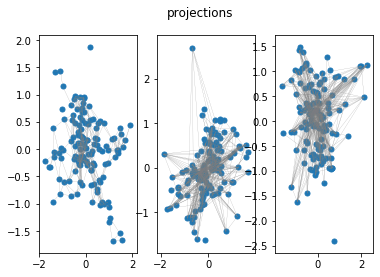

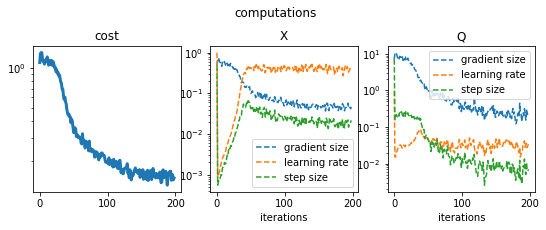

In [29]:
diss = mview.DISS(node_number=node_number,verbose=1)
diss.add_graph(edge_list=edge1,dissimilarity_list=dissimilarity1)
diss.add_graph(edge_list=edge2,dissimilarity_list=dissimilarity2)
diss.add_graph(edge_list=edge3,dissimilarity_list=dissimilarity3)

mv = mview.basic(diss, average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY(include_edges=True)
mv.figureH()

## Running MPSE using random 2D projections of 3D data

For purposes of experimentation, instead of specifying the dissimilarity relations, you can let MPSE do it for you.

By default, MPSE will construct dissimilarity relations that can exactly be recovered by MPSE in its default setting, that is, MPSE will produce the dissimilarity relations by:

1) assigning 3D coordinates to each node (uniformly at random from the unit ball centered at the origin in R3)

2) assigning a 2x3 projection matrix to each attribute (uniformly at random from the set of 2x3 orthogonal projection matrices, that is, using the Haar measure)


You must specify the number of nodes and attributes (the number of projections). 


Running MPSE in this default setting looks like this:

In [7]:
DD = {
    'nodes' : N,
    'attributes' : 3
}
mv = mview.basic(DD,
                 average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY()
mv.figureH()

NameError: name 'N' is not defined

To run the same exact experiment, but with fixed (and correct) projection matrices (which are randomly determined as described above), just specify that Q must be the True projection matrix, as shown below.

Note: this will only work in this setup, where MPSE is constructing the relations from exact data.

In [ ]:
DD = {
    'nodes' : N,
    'attributes' : 3
}
mv = mview.basic(DD,Q=True,
                 average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY()
mv.figureH()

To run the same experiment (without fixed projections), but starting with the standard projections (instead of random), run the code below.

Note: another option for fixed projections is 'cylinder' (which works for any number of attributes), or you can specify the list of projections directly (2x3 matrices by default).

In [ ]:
DD = {
    'nodes' : N,
    'attributes' : 3,
    'Q' : 'standard'
}
mv = mview.basic(DD,
                 average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY()
mv.figureH()

It is possible to make other changes to the dissimilarity set. For example, we can instead assign 4D positions to the nodes, fix 2 random projections of these positions into 2D, and consider the dissimilarity relations obtained from these to images. If we try to find an embedding in R3 (in the same way that we've done it before, we can't expect the global stress minimum to be zero (or maybe we can?).

In [ ]:
DD = {
    'nodes' : N,
    'attributes' : 2,
    'd1' : 4
}
mv = mview.basic(DD,
                 average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY()
mv.figureH()

Now we run the same experiment, but the dissimilarity relatiosn are obtained by measuring the distances after projecting from 4D positions into 3D 'images'. Again, MPSE is still trying to find a 3D embedding based on 2D images.

In [ ]:
DD = {
    'nodes' : N,
    'attributes' : 2,
    'd1' : 4,
    'd2' : 3
}
mv = mview.basic(DD,
                 average_neighbors=average_neighbors,
                 max_iter=max_iter,min_grad=min_grad,
                 verbose=2)
mv.figureY()
mv.figureH()

## Other

I'll add other input types soon.